In [1]:
import torch
import torch.nn as nn
from models import SEModular
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_masking
from generate_utils import generate_files_with_nucleus, generate_files_with_base2, generate_files_with_random, load_SE_Modular
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import save_attention_maps_with_split, save_attention_maps

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nvis = None
# curriculum_type, subfolder = 'base2', 'Q16_L256_PC_FR'
# curriculum_type, subfolder = 'base2', 'Q16_L320_bar_PC_FR'

# curriculum_type, subfolder = 'base2', 'Q4_L64_PC_FR'
# curriculum_type, subfolder = 'base2', 'Q4_L80_bar_PC_FR'

# curriculum_type, subfolder = 'base2', 'Q4_L80_bar_PC'
curriculum_type, subfolder = 'random', 'Q4_L80_bar_PC'
# curriculum_type, subfolder = 'f2f', 'Q4_L80_bar_PC'

In [3]:
total_stages = None if curriculum_type == 'f2f' else 10
condition_dim = None if 'bar' in subfolder else 16
trainable_pos_emb = False if curriculum_type == 'f2f' else True

grid_lenght = int(subfolder.split('_L')[1].split('_')[0])

intertwine_bar_info = 'bar' in subfolder

tokenizer = CSGridMLMTokenizer(
    fixed_length=grid_lenght,
    quantization='16th' if 'Q16' in subfolder else '4th',
    intertwine_bar_info=intertwine_bar_info,
    trim_start=False,
    use_pc_roll='PC' in subfolder,
    use_full_range_melody='FR' in subfolder
)

In [4]:
# val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
# val_dir = '/media/maindisk/data/synthetic_CA_test'

In [5]:
# curriculum_type = 'f2f'

# exponent, nvis = 5, None
# exponent, nvis = 5, 0
# exponent, nvis = 5, 5
# exponent, nvis = 5, 15
# exponent, nvis = 5, 31
# exponent, nvis = 5, 51

# exponent, nvis = 7, None
# exponent, nvis = 7, 0
# exponent, nvis = 7, 5
# exponent, nvis = 7, 15
# exponent, nvis = 7, 31
# exponent, nvis = 7, 51

# exponent, nvis = 10, None
# exponent, nvis = 10, 0
# exponent, nvis = 10, 5
# exponent, nvis = 10, 15
# exponent, nvis = 10, 31
# exponent, nvis = 10, 50

unmasking_order = 'start' # in ['random', 'start', 'end', 'certain', 'uncertain']

# subfolder = 'SE/CA'
# subfolder = 'SE/all12'
device_name = 'cuda:2'
model = load_SE_Modular(
    d_model=512, 
    nhead=8, 
    num_layers=8,
    curriculum_type=curriculum_type,
    subfolder=subfolder,
    device_name=device_name,
    tokenizer=tokenizer,
    grid_length=grid_lenght,
    condition_dim=condition_dim,  # if not None, add a condition token of this dim at start
    unmasking_stages=total_stages,  # if not None, use stage-based unmasking
    trainable_pos_emb=trainable_pos_emb,
    nvis=nvis
)

model_path:  saved_models/SE/Q4_L80_bar_PC/random.pt


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

25970147


In [7]:
import os
data_files = []
for dirpath, _, filenames in os.walk(val_dir):
    for file in filenames:
        if file.endswith('.xml') or file.endswith('.mxl') or file.endswith('.musicxml') \
            or file.endswith('.mid') or file.endswith('.midi'):
            full_path = os.path.join(dirpath, file)
            data_files.append(full_path)
print(len(data_files))

758


In [8]:
# val_idx = 1
# val_idx = 402
# val_idx = 401
# val_idx = 400
val_idx = 300 # besame
# TODO: check out 200, it has a problem rendering to file
# val_idx = 200

input_f = data_files[val_idx]
# input_f = 'example_inputs/test_midi_constraints.mid'

midi_folder = 'examples_MIDI/' + subfolder + '/' + curriculum_type
if nvis is not None:
    midi_folder += '_nvis' + str(nvis)
midi_folder += '_' + unmasking_order + '/'
os.makedirs(midi_folder, exist_ok=True)

# gen_harm, real_harm, gen_score, real_score, avg_diffs = generate_files_with_greedy(
# gen_harm, real_harm, gen_score, real_score, avg_diffs = generate_files_with_beam(
if curriculum_type == 'f2f':
    gen_harm, real_harm, gen_score, real_score = generate_files_with_nucleus(
        model=model,
        tokenizer=tokenizer,
        input_f=input_f,
        mxl_folder=None,
        midi_folder=midi_folder,
        name_suffix=curriculum_type,
        intertwine_bar_info=intertwine_bar_info,
        normalize_tonality=False,
        use_constraints=False,
        temperature=1.0,
        # beam_size=5,
        # top_k=50,
        p=0.9,
        unmasking_order=unmasking_order, # in ['random', 'start', 'end', 'certain', 'uncertain']
        create_gen=True,
        create_real=True
    )
elif curriculum_type == 'base2':
    gen_harm, real_harm, gen_score, real_score = generate_files_with_base2(
        model=model,
        tokenizer=tokenizer,
        input_f=input_f,
        mxl_folder=None,
        midi_folder=midi_folder,
        name_suffix=subfolder,
        use_constraints=False,
        normalize_tonality=False,
        num_stages=10,
        temperature=1.0,
        create_gen=True,
        create_real=False
    )
elif curriculum_type == 'random':
    gen_harm, real_harm, gen_score, real_score = generate_files_with_random(
        model=model,
        tokenizer=tokenizer,
        input_f=input_f,
        mxl_folder=None,
        midi_folder=midi_folder,
        name_suffix=subfolder,
        use_constraints=False,
        normalize_tonality=False,
        num_stages=10,
        temperature=1.0,
        create_gen=True,
        create_real=False
    )

In [9]:
tokenizer.ids_to_tokens[269]

'A:min'

In [10]:
# plt.plot(avg_diffs)

In [11]:
harm_string = '_'.join( gen_harm )
# print(gen_harm)
if '<bar>' in harm_string:
    harm_bars = harm_string.split( '<bar>_' )
    for h in harm_bars:
        print(h)
else:
    for i, h in enumerate(gen_harm):
        if i%(grid_lenght/16) == 0 and i > 0:
            print('')
        print(h + '_', end='')


A:min_A:min_A:min_A:min_
G:maj_G:maj_G:maj_G:maj_
F:maj_F:maj_F:maj_F:maj_
E:maj_E:maj_E:maj_E:maj_
A:min_A:min_A:min_A:min_
G:maj_G:maj_G:maj_G:maj_
F:maj_F:maj_F:maj_F:maj_
E:maj_E:maj_E:maj_E:maj_
A:min_A:min_A:min_A:min_
G:maj_G:maj_G:maj_G:maj_
F:maj_F:maj_F:maj_F:maj_
E:maj_E:maj_E:maj_E:maj_
A:min_A:min_A:min_A:min_
G:maj_G:maj_G:maj_G:maj_
F:maj_F:maj_F:maj_F:maj_
E:maj_E:maj_<pad>_<pad>


In [12]:
harm_string = '_'.join( real_harm )
# print(gen_harm)
if '<bar>' in harm_string:
    harm_bars = harm_string.split( '<bar>_' )
    for h in harm_bars:
        print(h)
else:
    for i, h in enumerate(real_harm):
        if i%(grid_lenght/16) == 0 and i > 0:
            print('')
        print(h + '_', end='')


A:min_A:min_A:min_A:min_
A:min_A:min_A:min_A:min_
D:min_D:min_B:hdim7_B:hdim7_
D:min7_D:min7_B:hdim7_B:hdim7_
D:min_D:min_E:dim_E:dim_
D:min_D:min_E:7_E:7_
A:min_A:min_E:7_E:7_
A:min_A:min_A:min_A:min_
A:7_A:7_A:7_A:7_
A:7_A:7_A:7_A:7_
D:min_D:min_D:min_D:min_
D:min7_D:min7_A:sus2_D:min_
A:min_A:min_A:min_A:min_
D#:min_D#:min_E:7_E:7_
A:min_A:min_D:min_B:hdim7_
A:min_A:min_A:min_A:min


<Axes: >

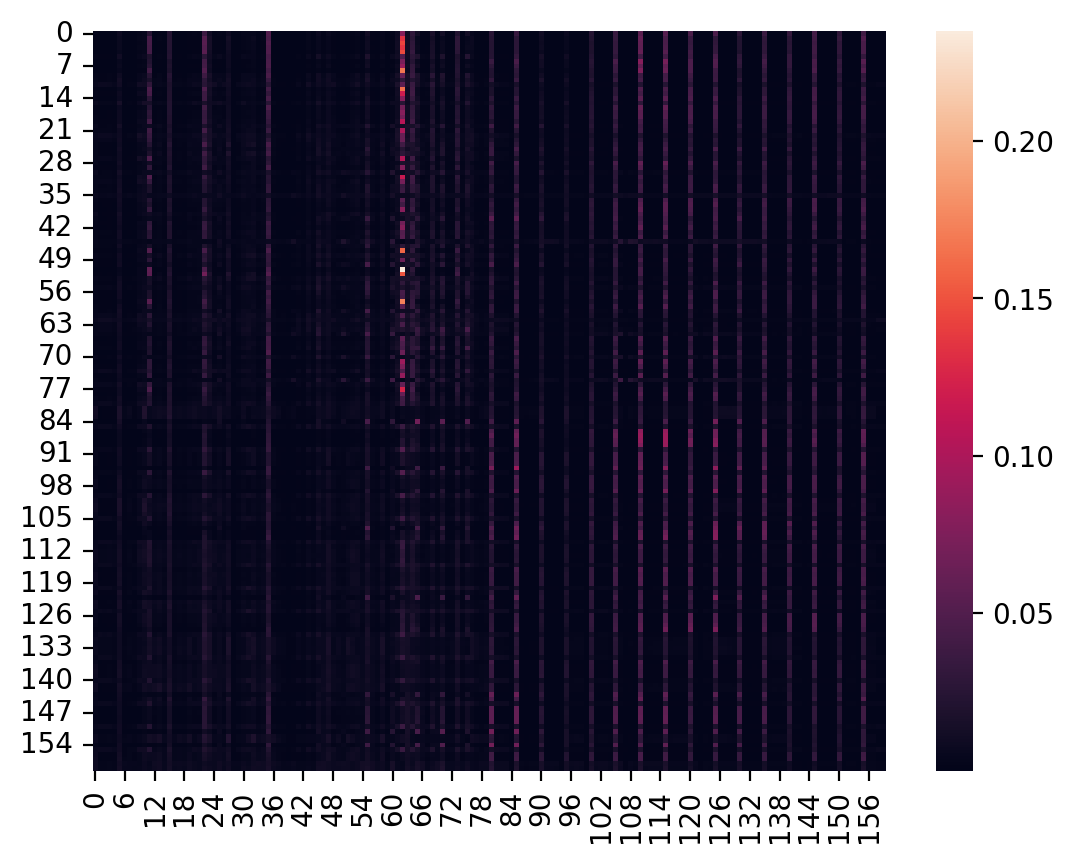

In [13]:
# After running a forward pass with attention outputs enabled
# attn_maps = model.harmony_encoder.layers[4].last_attn_weights  # example shape: [B, heads, L, L]
self_attns = model.get_attention_maps()

# Focus on one item in batch, one head
map = self_attns[0][0, 0].detach().cpu().numpy()
sns.heatmap(map)

In [14]:
save_dir='figs/attn_maps/' + subfolder + '/' + curriculum_type
if nvis is not None:
    save_dir += '_nvis' + str(nvis)

save_attention_maps_with_split(
    self_attns,
    melody_len=grid_lenght,
    save_dir=save_dir + '/self/',
    prefix='self'
)